# 1. Scikit Learn and Orange Examples - Transparent Models

For our experiments we will use "Breast Cancer" dataset, which you can access via sklearn library

In [3]:
from sklearn import datasets,model_selection
breastCancer = datasets.load_breast_cancer()
X = breastCancer.data
y = breastCancer.target
target_names = breastCancer.target_names
feature_names = breastCancer.feature_names
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

## Firstly, Let's try a simple decision tree, which is explainable too!

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=0)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Simple Decision Tree Performance:")
print(classification_report(y_test,y_pred,target_names=target_names))

Simple Decision Tree Performance:
              precision    recall  f1-score   support

   malignant       0.88      0.95      0.92        63
      benign       0.97      0.93      0.95       108

   micro avg       0.94      0.94      0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171



So, decision trees have good performance on this dataset.

Let's visualize that tree

In [5]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive
from graphviz import Source

def plot_tree(depth):
    estimator = DecisionTreeClassifier(random_state = 0 
          , criterion = 'gini'
          , max_depth = depth)
    estimator.fit(x_train, y_train)
    graph = Source(export_graphviz(estimator
          , out_file=None
          , feature_names=feature_names
          , class_names=target_names
          , filled = True))
    print(classification_report(estimator.predict(x_test),y_test,target_names=target_names))
    display(SVG(graph.pipe(format='svg')))
    return estimator
inter=interactive(plot_tree 
   , depth=(1,5))
display(inter)


interactive(children=(IntSlider(value=3, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Moreover, we can give the feature importance, that trees computed in a graph!

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

def plot_trees_graph(depth):
    estimator = DecisionTreeClassifier(random_state = 0 
          , criterion = 'gini'
          , max_depth = depth)
    estimator.fit(x_train, y_train)
    print(classification_report(estimator.predict(x_test),y_test,target_names=target_names))
    weights = estimator.feature_importances_
    model_weights = pd.DataFrame({ 'features': list(feature_names),'weights': list(weights)})
    model_weights = model_weights.sort_values(by='weights', ascending=False)
    plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
    sns.barplot(x="weights", y="features", data=model_weights)
    plt.xticks(rotation=90)
    plt.show()
    return estimator
inter=interactive(plot_trees_graph 
   , depth=(1,5))
display(inter)

interactive(children=(IntSlider(value=3, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

## Now, lets try a linear model, which is explainable too!

In [8]:
from sklearn.linear_model import LogisticRegression

lin_model = LogisticRegression(solver='newton-cg',penalty='l2',max_iter=1000,C=10000,random_state=0)#vale k l1 me liblinear
#lin_model = LogisticRegression(penalty='l1',max_iter=1000,C=10000,random_state=0)#vale k l1 me liblinear
#Try for l1 penalty too!
lin_model.fit(x_train,y_train)
y_pred = lin_model.predict(x_test)
print("Simple Linear Model Performance:")
print(classification_report(y_test,y_pred,target_names=target_names))

Simple Linear Model Performance:
              precision    recall  f1-score   support

   malignant       0.94      0.92      0.93        63
      benign       0.95      0.96      0.96       108

   micro avg       0.95      0.95      0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



So, now we are going to visualize the feature's coefficient. Thankfully, linear models like logistic regression take their decisions based on weights they allocate on the features. On logistic regression we have the coefficient of a feature

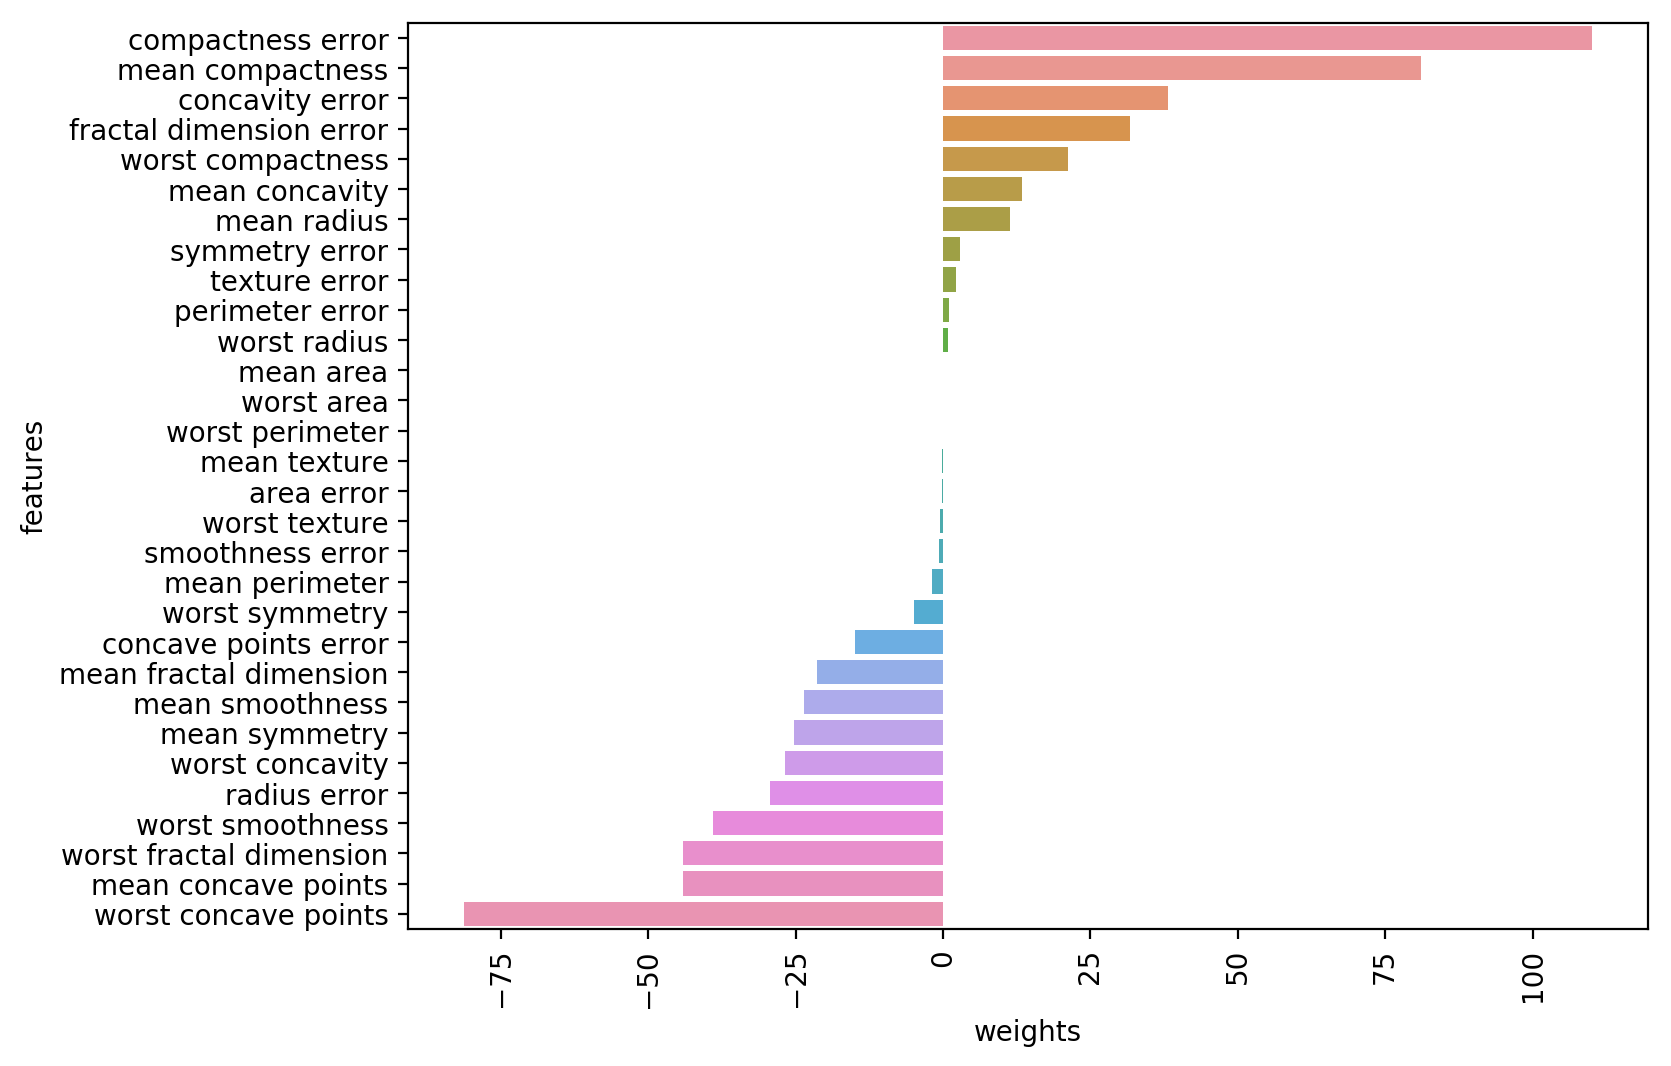

In [9]:
weights = lin_model.coef_
model_weights = pd.DataFrame({ 'features': list(feature_names),'weights': list(weights[0])})
model_weights = model_weights.sort_values(by='weights', ascending=False)
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
sns.barplot(x="weights", y="features", data=model_weights)
plt.xticks(rotation=90)
plt.show()

## Lastly, lets try a rule based model, which is explainable too!


Finally, we are going to use Orange library to build a rule based classifier, in order to extract the rules.

In [11]:
import Orange
import Orange.evaluation.scoring
import Orange.classification.rules
import Orange.evaluation

learner = Orange.classification.rules.CN2Learner()
data = Orange.data.Table(x_train, y_train)
print("CN2 Ordered with Entropy Performance:")
def plot_rules(bw, mce, mrl):
    learner.rule_finder.quality_evaluator = Orange.classification.rules.EntropyEvaluator()
    learner.rule_finder.search_algorithm.beam_width = bw
    learner.rule_finder.general_validator.min_covered_examples = mce
    learner.rule_finder.general_validator.max_rule_length = mrl
    results = Orange.evaluation.testing.CrossValidation(data, [learner])
    mymodel = learner.fit(np.asarray(x_train), np.asarray(y_train))
    predicted = mymodel.predict(np.asarray(x_test))
    mypred = []
    for iii in predicted:
        if (iii[0] >= iii[1]):
            mypred.append(0)
        else:
            mypred.append(1)
    print(classification_report(y_test,y_pred,target_names=target_names))
    model = learner(data)
    for rule in model.rule_list:
        rule = str(rule).replace("Class=v1", "malignant").replace("Class=v2", "benign")
        for i in range(len(feature_names)-1,0,-1):
            num = ""
            if i<10:
                num = "0"+str(i)
            else:
                num = str(i)
            rule = rule.replace("Feature "+num, "("+ feature_names[i] + ")")
        print(rule)
    print()
    return learner

inter=interactive(plot_rules 
                ,bw = [3,5,8,10]
                ,mce = [7,9,11]
                ,mrl = [2,3,5,10])
display(inter)

CN2 Ordered with Entropy Performance:


interactive(children=(Dropdown(description='bw', options=(3, 5, 8, 10), value=3), Dropdown(description='mce', …

This requirements.txt file is on the github folder in case you want to run those examples yourself.

In [12]:
!pip freeze > requirements.txt